# Raach Chaima Et Kousai Ghaouari

## Importer Les Bibliothèques necessaires

In [74]:
import cv2 as cv  
import numpy as np  
from matplotlib import pyplot as plt
import numpy as np 
from skimage import data 
from skimage.util import img_as_ubyte 
from skimage import exposure 
import skimage.morphology as morp 
from skimage.filters import rank 
from skimage.io import imsave, imread
import pandas as pd

## Fonctions Utiles

La fonction QDHE est une implémentation de l'algorithme QDHE (Quantum-Dot Histogram Equalization), qui est basé sur la médiane. Cet algorithme segmente le nombre de pixels de manière équitable dans chaque sous-histogramme. Initialement, il divise l'histogramme original de l'image en deux sous-histogrammes. Ensuite, il utilise les médianes des deux sous-histogrammes partitionnés comme points de séparation pour diviser encore les deux sous-histogrammes en deux sous-histogrammes plus petits chacun, créant ainsi quatre sous-histogrammes. Après cela, sur chaque histogramme, il effectue le clipping, l'allocation de nouveaux niveaux de gris, puis l'égalisation de l'histogramme.

In [75]:
def calculate_dynamic_ranges(cdf, m1, m2, m3):
    L = 256
    total_pixels = cdf[-1]
    spans = [m1, m2 - m1, m3 - m2, total_pixels - m3]
    range_starts = np.zeros(4, dtype=int)
    range_ends = np.zeros(4, dtype=int)
    sum_spans = sum(spans)
    for i in range(4):
        range_i = (L - 1) * spans[i] // sum_spans
        range_starts[i] = range_ends[i-1] + 1 if i > 0 else 0
        range_ends[i] = range_starts[i] + range_i
    return range_starts, range_ends


def QDHE(image):
    hist, _ = np.histogram(image.flatten(), bins=256, range=(0, 256))
    cdf = hist.cumsum()
    m1, m2, m3 = (np.percentile(cdf, q) for q in [25, 50, 75])

    clip_limit = np.mean(image)
    clipped_hist = apply_clipping(hist, clip_limit)
    clipped_cdf = clipped_hist.cumsum()

    range_starts, range_ends = calculate_dynamic_ranges(clipped_cdf, m1, m2, m3)

    equalized_image = np.zeros_like(image)
    for i in range(4):
        mask = (image >= range_starts[i]) & (image <= range_ends[i])
        sub_image = image[mask]
        
        sub_hist, _ = np.histogram(sub_image, bins=np.arange(256), range=(0, 255))
        sub_cdf = sub_hist.cumsum()
        sub_cdf_normalized = sub_cdf * (range_ends[i] - range_starts[i]) / sub_cdf[-1] + range_starts[i]
        equalized_image[mask] = sub_cdf_normalized[sub_image - range_starts[i]]
    
    return equalized_image

La fonction CHE effectue un Égalisation Cumulative de l'Histogramme sur une image. Elle calcule d'abord le nombre total de pixels, puis utilise la somme cumulative de l'histogramme pour normaliser les valeurs d'intensité. Cela permet d'étendre le contraste de l'image en répartissant uniformément les valeurs d'intensité. La fonction interpole ensuite ces valeurs pour ajuster l'image originale, améliorant ainsi le contraste global.

In [76]:
def CHE(hist_img,img,bin_centers):
    total_pixels=img.shape[0]*img.shape[1]
    cum_sum=hist_img.cumsum()
    cdf=np.round(
        ((cum_sum-np.min(cum_sum))/(total_pixels-np.min(cum_sum)))*255
    ).astype(int)

    out = np.interp(img.flatten(), bin_centers, cdf).astype(int)
    out = out.reshape(img.shape)
    return out

La classe Metrics comporte les métriques nécessaires pour évaluer les performances des techniques d'égalisation des histogrammes.

In [77]:
class Metrics():
    
    def __init__(self,img,new_img):
        self.img=img
        self.new_img=new_img
        
    def MSE(self):
        return (np.sum(np.square(self.img-self.new_img)))/(self.img.shape[0]*self.img.shape[1])

    def PSNR(self):
        return (10*np.log10(255**2))/self.MSE()
    
    def SD(self):
        height=self.new_img.shape[0]
        width=self.new_img.shape[1]
        X=np.mean(self.new_img)
        cum_sum=0
        for i in range(height):
            for j in range(width):
                cum_sum=cum_sum+np.square(self.new_img[i,j]-X)
        return np.sqrt((1/((width*height)-1))*cum_sum)


La fonction return_metrics charge une image en niveaux de gris, applique différentes techniques d'égalisation d'histogramme (HE, CHE, QDHE, CLAHE), et affiche l'image originale, ses versions améliorées, et leurs histogrammes. Elle calcule ensuite les métriques (MSE, PSNR, SD) pour chaque méthode d'amélioration et les présente dans un DataFrame. Cela permet une comparaison visuelle et quantitative de l'efficacité de chaque technique d'égalisation sur l'image donnée.

In [78]:
def return_metrics(path):
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    equ=equ = cv.equalizeHist(img)
    plt.rcParams['figure.figsize'] = [16, 16]
    fig, axes = plt.subplots(5, 2)
    # Plot original image and its histogram
    ax_img, ax_img_hist = axes[0]
    hist_img, bins_img = np.histogram(img.flatten(), 256, [0, 256]) 
    cdf_img = hist_img.cumsum() 
    cdf_img_normalized = cdf_img * float(hist_img.max()) / cdf_img.max() 
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_title(path)
    ax_img.set_axis_off()
    ax_img_hist.plot(cdf_img_normalized, color='b')
    ax_img_hist.hist(img.flatten(), 256, [0, 256], color='r')
    ax_img_hist.set_xlim([0, 256])
    ax_img_hist.set_title('Histogram')
    ax_img_hist.set_ylabel('Frequency')
    #plot HE
    ax_img, ax_img_hist = axes[1]
    hist_img, bins_img = np.histogram(equ.flatten(), 256, [0, 256]) 
    cdf_img_equ = hist_img.cumsum() 
    cdf_img_normalized = cdf_img * float(hist_img.max()) / cdf_img.max() 
    ax_img.imshow(equ, cmap=plt.cm.gray)
    ax_img.set_title("HE")
    ax_img.set_axis_off()
    ax_img_hist.plot(cdf_img_normalized, color='b')
    ax_img_hist.hist(equ.flatten(), 256, [0, 256], color='r')
    ax_img_hist.set_xlim([0, 256])
    ax_img_hist.set_title('Histogram')
    ax_img_hist.set_ylabel('Frequency')





    # Plot CHE
    bins_centers = bins_img[:-1]
    img_cdf = CHE(hist_img, img, bins_centers)
    ax_che, ax_che_hist = axes[2]
    hist_che, bins_cdf = np.histogram(img_cdf.flatten(), 256, [0, 256]) 
    cdf_cdf = hist_che.cumsum() 
    cdf_cdf_normalized = cdf_cdf * float(hist_che.max()) / cdf_cdf.max() 
    ax_che.imshow(img_cdf, cmap=plt.cm.gray)
    ax_che.set_title('CHE')
    ax_che.set_axis_off()
    ax_che_hist.plot(cdf_cdf_normalized, color='b')
    ax_che_hist.hist(img_cdf.flatten(), 256, [0, 256], color='r')
    ax_che_hist.set_xlim([0, 256])
    ax_che_hist.set_title('Histogram')
    ax_che_hist.set_ylabel('Frequency')

    # Plot local equalization (QDHE)
    img_qdhe = QDHE( img)
    ax_local, ax_local_hist = axes[3]
    hist_local, bins_local = np.histogram(img_qdhe.flatten(), 256, [0, 256]) 
    cdf_local = hist_local.cumsum() 
    cdf_local_normalized = cdf_local * float(hist_local.max()) / cdf_local.max() 
    ax_local.imshow(img_qdhe, cmap=plt.cm.gray)
    ax_local.set_title('QDHE')
    ax_local.set_axis_off()
    ax_local_hist.plot(cdf_local_normalized, color='b')
    ax_local_hist.hist(img_qdhe.flatten(), 256, [0, 256], color='r')
    ax_local_hist.set_xlim([0, 256])
    ax_local_hist.set_title('Histogram')
    ax_local_hist.set_ylabel('Frequency')

    # Plot CLAHE
    clahe = cv.createCLAHE(clipLimit=10.0, tileGridSize=(16,16)) 
    cl1 = clahe.apply(img)
    ax_clahe, ax_clahe_hist = axes[4]
    hist_clahe, bins_clahe = np.histogram(cl1.flatten(), 256, [0, 256]) 
    cdf_clahe = hist_clahe.cumsum() 
    cdf_clahe_normalized = cdf_clahe * float(hist_clahe.max()) / cdf_clahe.max() 
    ax_clahe.imshow(cl1, cmap=plt.cm.gray)
    ax_clahe.set_title('CLAHE')
    ax_clahe.set_axis_off()
    ax_clahe_hist.plot(cdf_clahe_normalized, color='b')
    ax_clahe_hist.hist(cl1.flatten(), 256, [0, 256], color='r')
    ax_clahe_hist.set_xlim([0, 256])
    ax_clahe_hist.set_title('Histogram')
    ax_clahe_hist.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    recised_image=cv.resize(img,(equ.shape[0],equ.shape[1]))
    metric_he=Metrics(img=recised_image,new_img=equ)
    metric_cdf=Metrics(img=recised_image,new_img=img_cdf)
    metric_qdhe=Metrics(img=recised_image,new_img=img_qdhe)
    metric_clahe=Metrics(img=recised_image,new_img=cl1)
    metrics_data = {
    'Method': ['HE', 'CHE', 'QDHE', 'CLAHE'],
    'MSE': [metric_he.MSE(), metric_cdf.MSE(), metric_qdhe.MSE(), metric_clahe.MSE()],
    'PSNR': [metric_he.PSNR(), metric_cdf.PSNR(), metric_qdhe.PSNR(), metric_clahe.PSNR()],
    'SD': [metric_he.SD(), metric_cdf.SD(), metric_qdhe.SD(), metric_clahe.SD()]
    }

    metrics_df = pd.DataFrame(metrics_data)
    metrics_df
    return metrics_df

## Manipulation d’histogramme - Egalisation

Préparation de l'image "vallee.png" pour l'égalisation d'histogramme en la convertissant d'abord en niveaux de gris avec OpenCV.

In [79]:
path = "vallee.png"

In [80]:
img = cv.imread(path)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

On affiche l'image "vallee.png", convertie en niveaux de gris, avec cmap grise pour une visualisation précise de l'intensité des pixels. Les paramètres vmin et vmax assurent que l'échelle de gris est étendue sur la gamme complète de valeurs possibles de 0 à 255, optimisant ainsi le contraste pour l'observation.

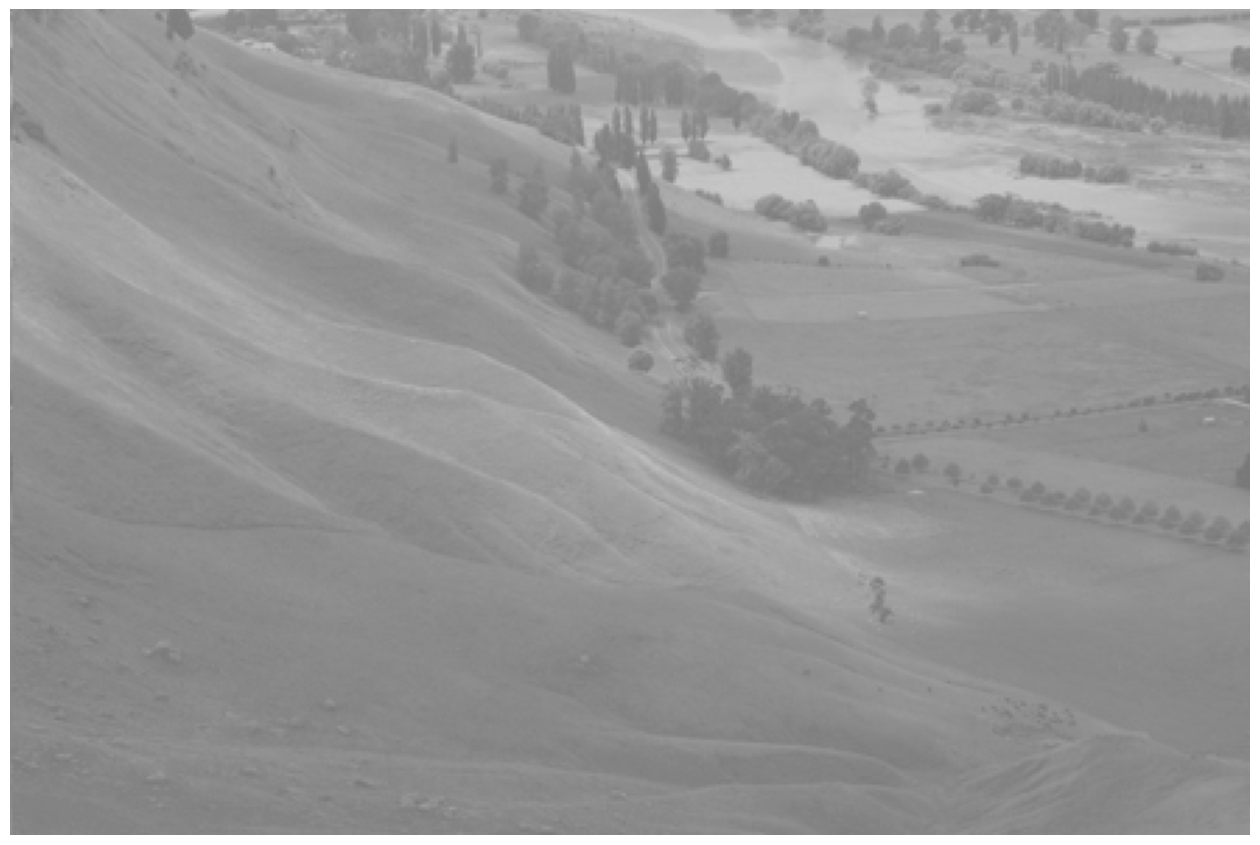

In [81]:
plt.imshow(img,cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.show()

### Histogram Equalization


On calcule l'histogramme de l'image avec np.histogram, puis on génère le CDF cumulatif avec cumsum. Cela prépare les données pour l'égalisation d'histogramme, une étape clé pour améliorer le contraste.

In [82]:
hist,bins = np.histogram(img.flatten(),256,[0,256])  
cdf = hist.cumsum()

On normalise le CDF et on affiche le CDF et l'histogramme de l'image. Cela aide à visualiser l'effet de l'égalisation à venir.

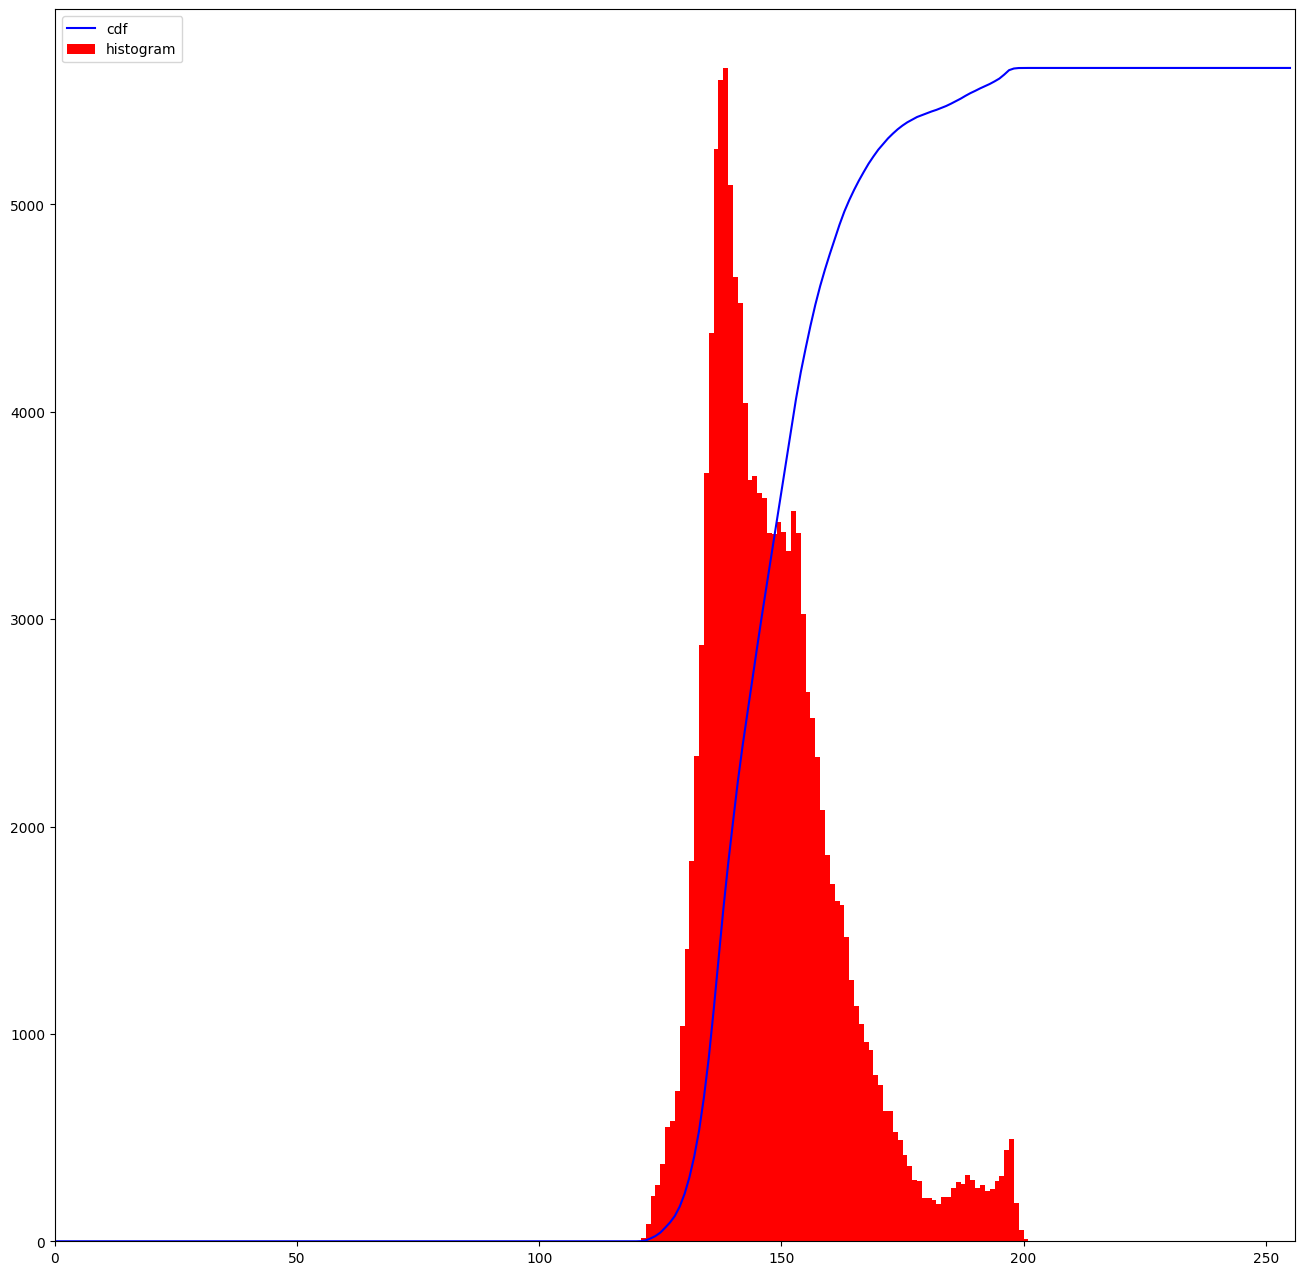

In [83]:
cdf_normalized = cdf * float(hist.max()) / cdf.max() 
plt.plot(cdf_normalized, color = 'b') 
plt.hist(img.flatten(),256,[0,256], color = 'r') 
plt.xlim([0,256])  
plt.legend(('cdf','histogram'), loc = 'upper left')  
plt.show()

Interprétation:

On visualise un graphique combiné d'un histogramme et de la fonction de distribution cumulative (CDF) pour l'image donnée. L'histogramme (en rouge) indique la fréquence des niveaux d'intensité lumineuse dans l'image, tandis que le CDF (en bleu) montre la somme cumulative de ces fréquences.
L'histogramme est concentré sur les tons moyens à foncés, indiquant que l'image est globalement sombre.
Le CDF monte rapidement et atteint la saturation plus tôt, ce qui suggère qu'une égalisation de l'histogramme pourrait répartir les intensités plus uniformément, améliorant ainsi le contraste de l'image.

In [84]:
equ = cv.equalizeHist(img)

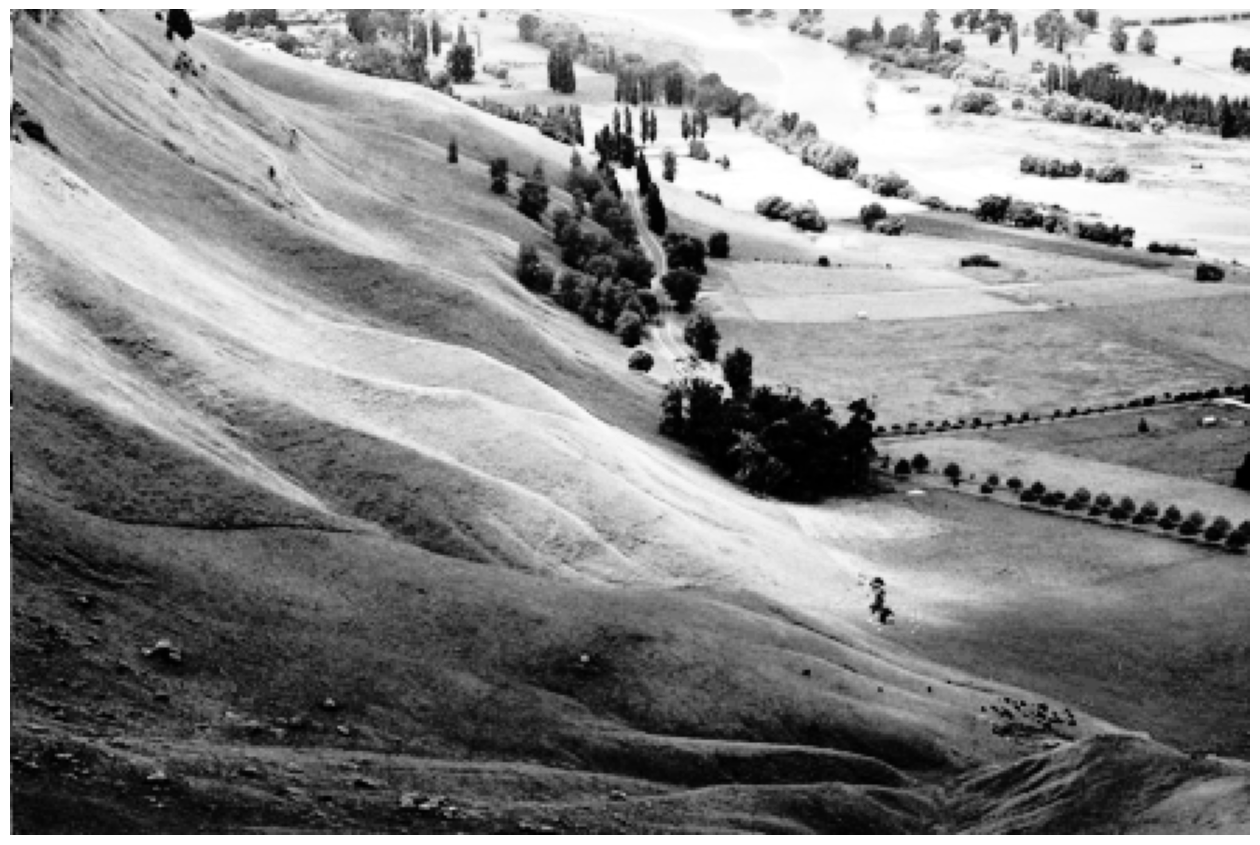

In [85]:
plt.imshow(equ,cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.show()

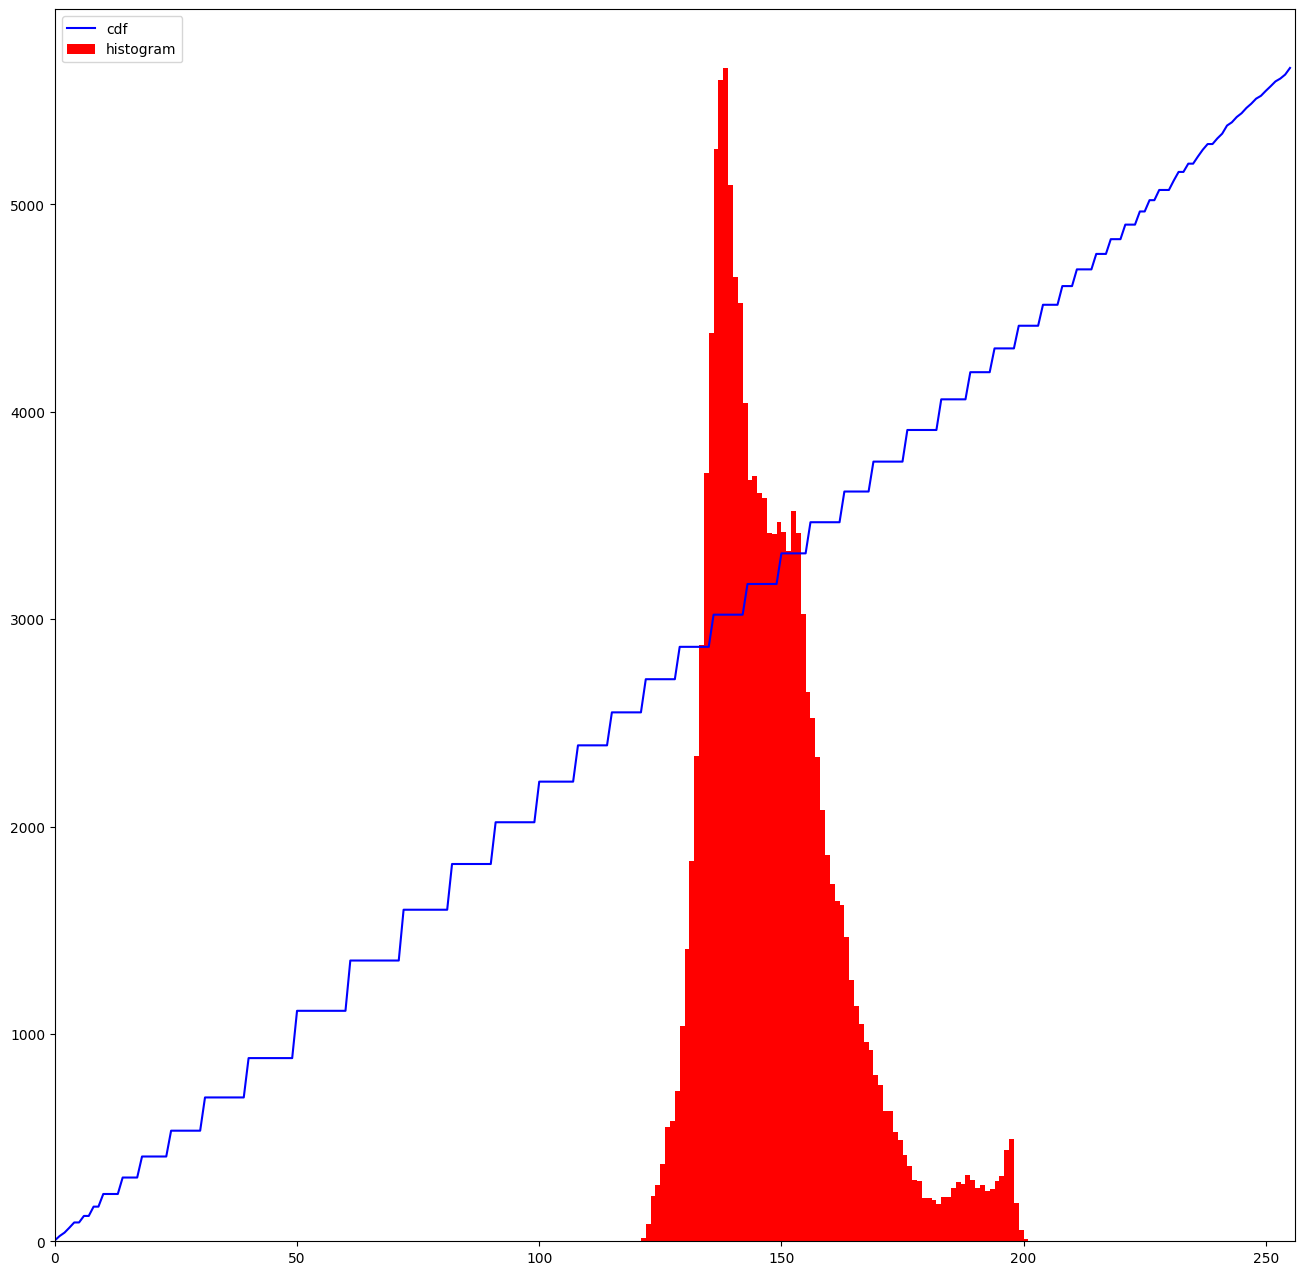

In [86]:
hist,bins = np.histogram(equ.flatten(),256,[0,256]) 
cdf = hist.cumsum() 
cdf_normalized = cdf * float(hist.max()) / cdf.max() 
plt.plot(cdf_normalized, color = 'b') 
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256]) 
plt.legend(('cdf','histogram'), loc = 'upper left') 
plt.show() 

Interprétation :


Les deux images précédentes représentent l'histogramme et la fonction de distribution cumulative (CDF) après l'égalisation d'histogramme de l'image. La première image illustre l'image égalisée où le contraste a été remarquablement amélioré. La deuxième image affiche l'histogramme et le CDF après égalisation : l'histogramme (en rouge) montre une répartition plus large des intensités de pixels, tandis que le CDF (en bleu) montre une courbe plus linéaire. Cela indique que l'égalisation a permis de mieux répartir les niveaux de gris, ce qui est cohérent avec une augmentation du contraste et une meilleure visibilité des détails sur toute l'image.

### Adaptive Histogram Equalization

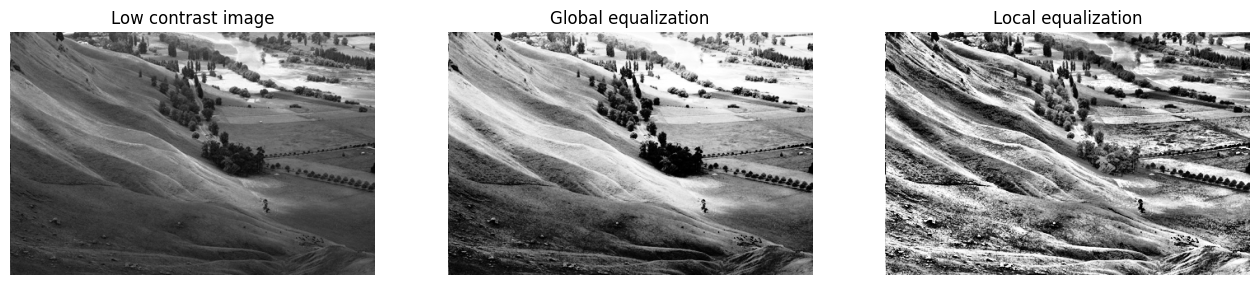

In [87]:
img = img_as_ubyte(imread(path, as_gray=True))
img_global = exposure.equalize_hist(img)
kernel = morp.disk(30)
img_local = rank.equalize(img, kernel)
plt.rcParams['figure.figsize'] = [16, 16]
fig, (ax_img, ax_global, ax_local) = plt.subplots(1, 3)
ax_img.imshow(img, cmap=plt.cm.gray)
ax_img.set_title('Low contrast image')
ax_img.set_axis_off()
ax_global.imshow(img_global, cmap=plt.cm.gray)
ax_global.set_title('Global equalization')
ax_global.set_axis_off()
ax_local.imshow(img_local, cmap=plt.cm.gray)
ax_local.set_title('Local equalization')
ax_local.set_axis_off()
plt.show()

On charge d'abord l'image en niveaux de gris, puis on applique une égalisation globale, suivie d'une égalisation locale.


 Les résultats sont visualisés côte à côte : l'image originale à faible contraste, l'image après égalisation globale montrant un contraste amélioré sur l'ensemble de l'image, et l'image après égalisation locale qui révèle des détails plus fins dans des zones spécifiques grâce à l'égalisation basée sur des régions locales.

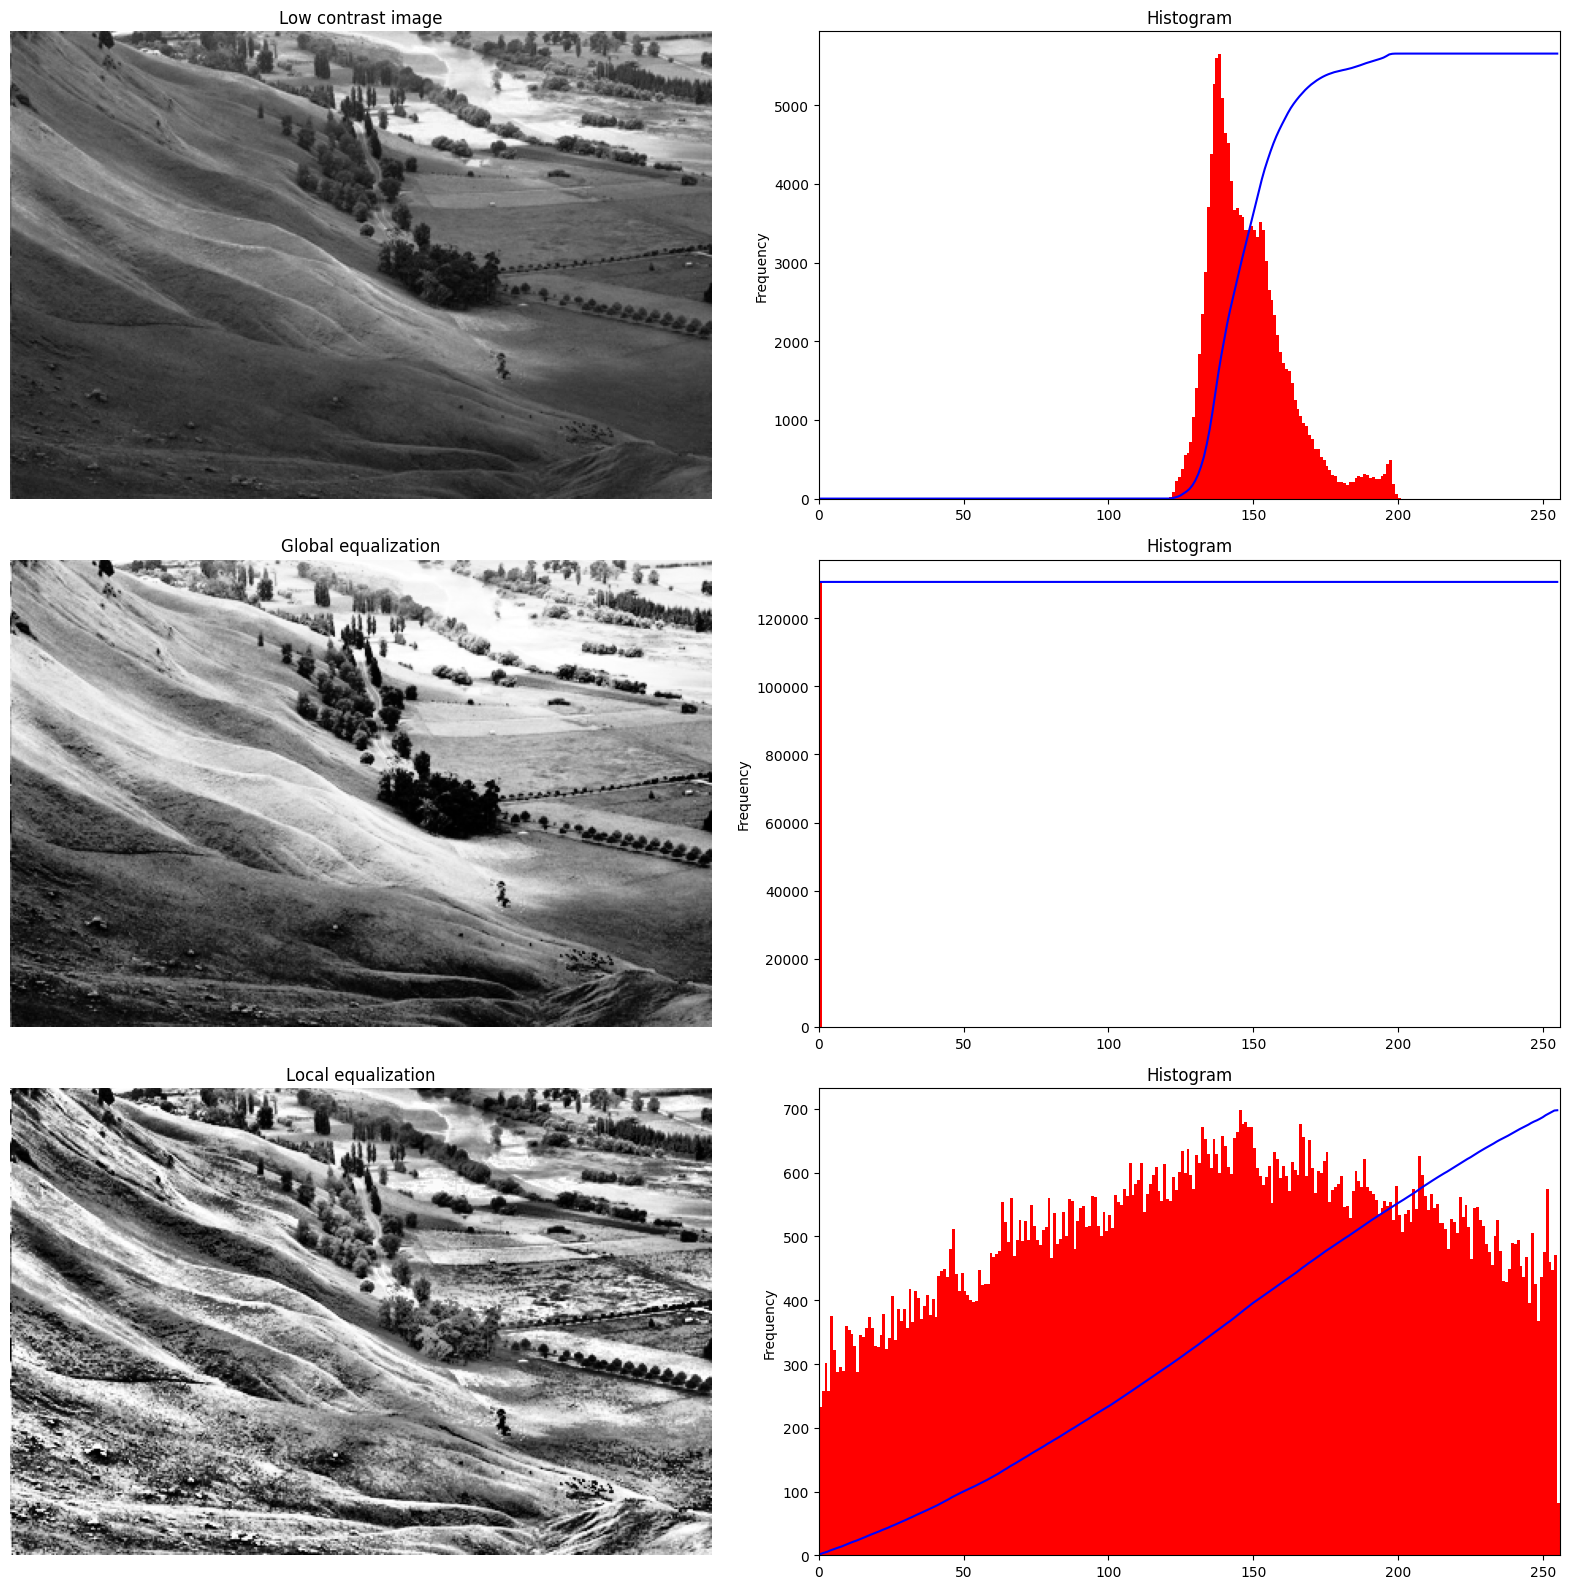

In [88]:
plt.rcParams['figure.figsize'] = [16, 16]
fig, axes = plt.subplots(3, 2)
ax_img, ax_img_hist = axes[0]
hist_img, bins_img = np.histogram(img.flatten(), 256, [0, 256]) 
cdf_img = hist_img.cumsum() 
cdf_img_normalized = cdf_img * float(hist_img.max()) / cdf_img.max() 
ax_img.imshow(img, cmap=plt.cm.gray)
ax_img.set_title('Low contrast image')
ax_img.set_axis_off()
ax_img_hist.plot(cdf_img_normalized, color='b')
ax_img_hist.hist(img.flatten(), 256, [0, 256], color='r')
ax_img_hist.set_xlim([0, 256])
ax_img_hist.set_title('Histogram')
ax_img_hist.set_ylabel('Frequency')
ax_global, ax_global_hist = axes[1]
hist_global, bins_global = np.histogram(img_global.flatten(), 256, [0, 256]) 
cdf_global = hist_global.cumsum() 
cdf_global_normalized = cdf_global * float(hist_global.max()) / cdf_global.max() 
ax_global.imshow(img_global, cmap=plt.cm.gray)
ax_global.set_title('Global equalization')
ax_global.set_axis_off()
ax_global_hist.plot(cdf_global_normalized, color='b')
ax_global_hist.hist(img_global.flatten(), 256, [0, 256], color='r')
ax_global_hist.set_xlim([0, 256])
ax_global_hist.set_title('Histogram')
ax_global_hist.set_ylabel('Frequency')
ax_local, ax_local_hist = axes[2]
hist_local, bins_local = np.histogram(img_local.flatten(), 256, [0, 256]) 
cdf_local = hist_local.cumsum() 
cdf_local_normalized = cdf_local * float(hist_local.max()) / cdf_local.max() 
ax_local.imshow(img_local, cmap=plt.cm.gray)
ax_local.set_title('Local equalization')
ax_local.set_axis_off()
ax_local_hist.plot(cdf_local_normalized, color='b')
ax_local_hist.hist(img_local.flatten(), 256, [0, 256], color='r')
ax_local_hist.set_xlim([0, 256])
ax_local_hist.set_title('Histogram')
ax_local_hist.set_ylabel('Frequency')
plt.tight_layout()
plt.show()


- Image à faible contraste: L'histogramme est concentré sur les tons moyens, manquant de répartition équilibrée des valeurs claires et sombres.


- Égalisation globale: L'histogramme est plus étendu, indiquant une répartition uniforme des intensités à travers l'image, résultant en un meilleur contraste global.


- Égalisation locale: L'histogramme montre des variations plus complexes, reflétant un ajustement du contraste qui varie localement, ce qui revele des détails fins dans différentes régions de l'image.

### Contrastive Limited Adaptive Equalization 

On utilise CLAHE sur une image en niveaux de gris pour améliorer localement le contraste sans amplifier le bruit. Avec des paramètres spécifiques, on applique l'égalisation de manière adaptative par blocs de l'image, ce qui permet d'obtenir des détails plus nets et un contraste amélioré là où c'est nécessaire.

In [89]:
plt.rcParams['figure.figsize'] = [8, 8]

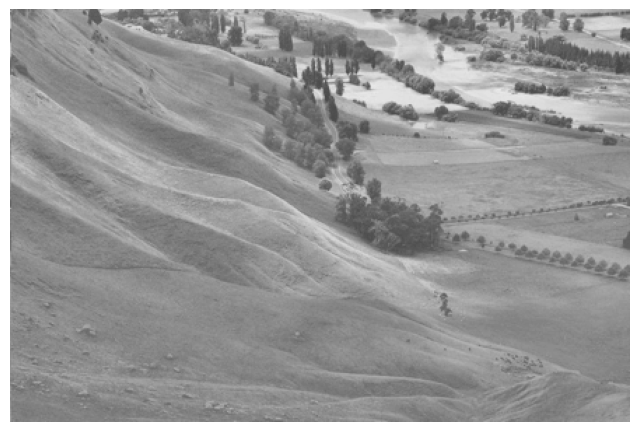

In [90]:
img = cv.imread(path) 
grayimg = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) 
cl1 = clahe.apply(grayimg) 
plt.imshow(cl1,cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.show()

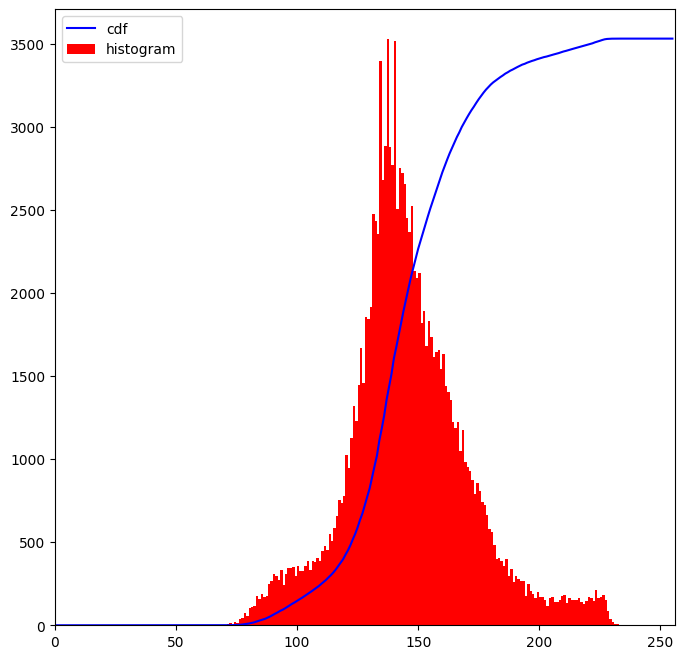

In [91]:
hist,bins = np.histogram(cl1.flatten(),256,[0,256]) 
cdf = hist.cumsum() 
cdf_normalized = cdf * float(hist.max()) / cdf.max() 
plt.plot(cdf_normalized, color = 'b') 
plt.hist(cl1.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256]) 
plt.legend(('cdf','histogram'), loc = 'upper left') 
plt.show() 

On génère l'histogramme et le CDF pour l'image traitée par CLAHE. L'histogramme montre une meilleure répartition des intensités après l'égalisation adaptative. Le CDF monte de façon plus régulière par rapport à l'image non traitée, ce qui signifie que les intensités lumineuses sont plus uniformément distribuée.

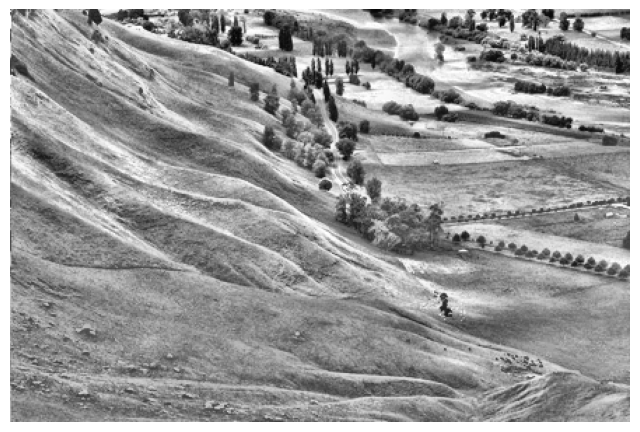

In [92]:
clahe = cv.createCLAHE(clipLimit=10.0, tileGridSize=(16,16)) 
cl1 = clahe.apply(grayimg) 
plt.imshow(cl1,cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.show()

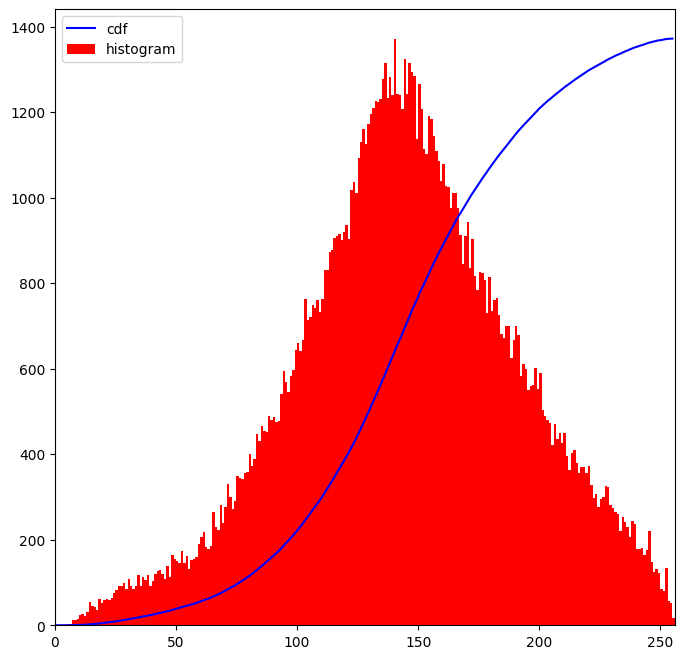

In [93]:
hist,bins = np.histogram(cl1.flatten(),256,[0,256]) 
cdf = hist.cumsum() 
cdf_normalized = cdf * float(hist.max()) / cdf.max() 
plt.plot(cdf_normalized, color = 'b') 
plt.hist(cl1.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256]) 
plt.legend(('cdf','histogram'), loc = 'upper left') 
plt.show() 

On applique CLAHE avec un clip limit plus élevé et une taille de grille plus grande, ce qui est utile pour des ajustements plus subtils du contraste sur de plus grandes zones.


 L'image traitée montre un contraste amélioré. L'histogramme et le CDF après CLAHE révèlent une distribution des intensités plus homogène et moins concentrée, indiquant un contraste mieux réparti dans l'image.

## Etude des différent de méthodes d'égalisation présentés dans La papier

C:\Users\HP\AppData\Local\Temp\ipykernel_13596\3560982479.py:33: RuntimeWarning: invalid value encountered in divide
  sub_cdf_normalized = sub_cdf * (range_ends[i] - range_starts[i]) / sub_cdf[-1] + range_starts[i]


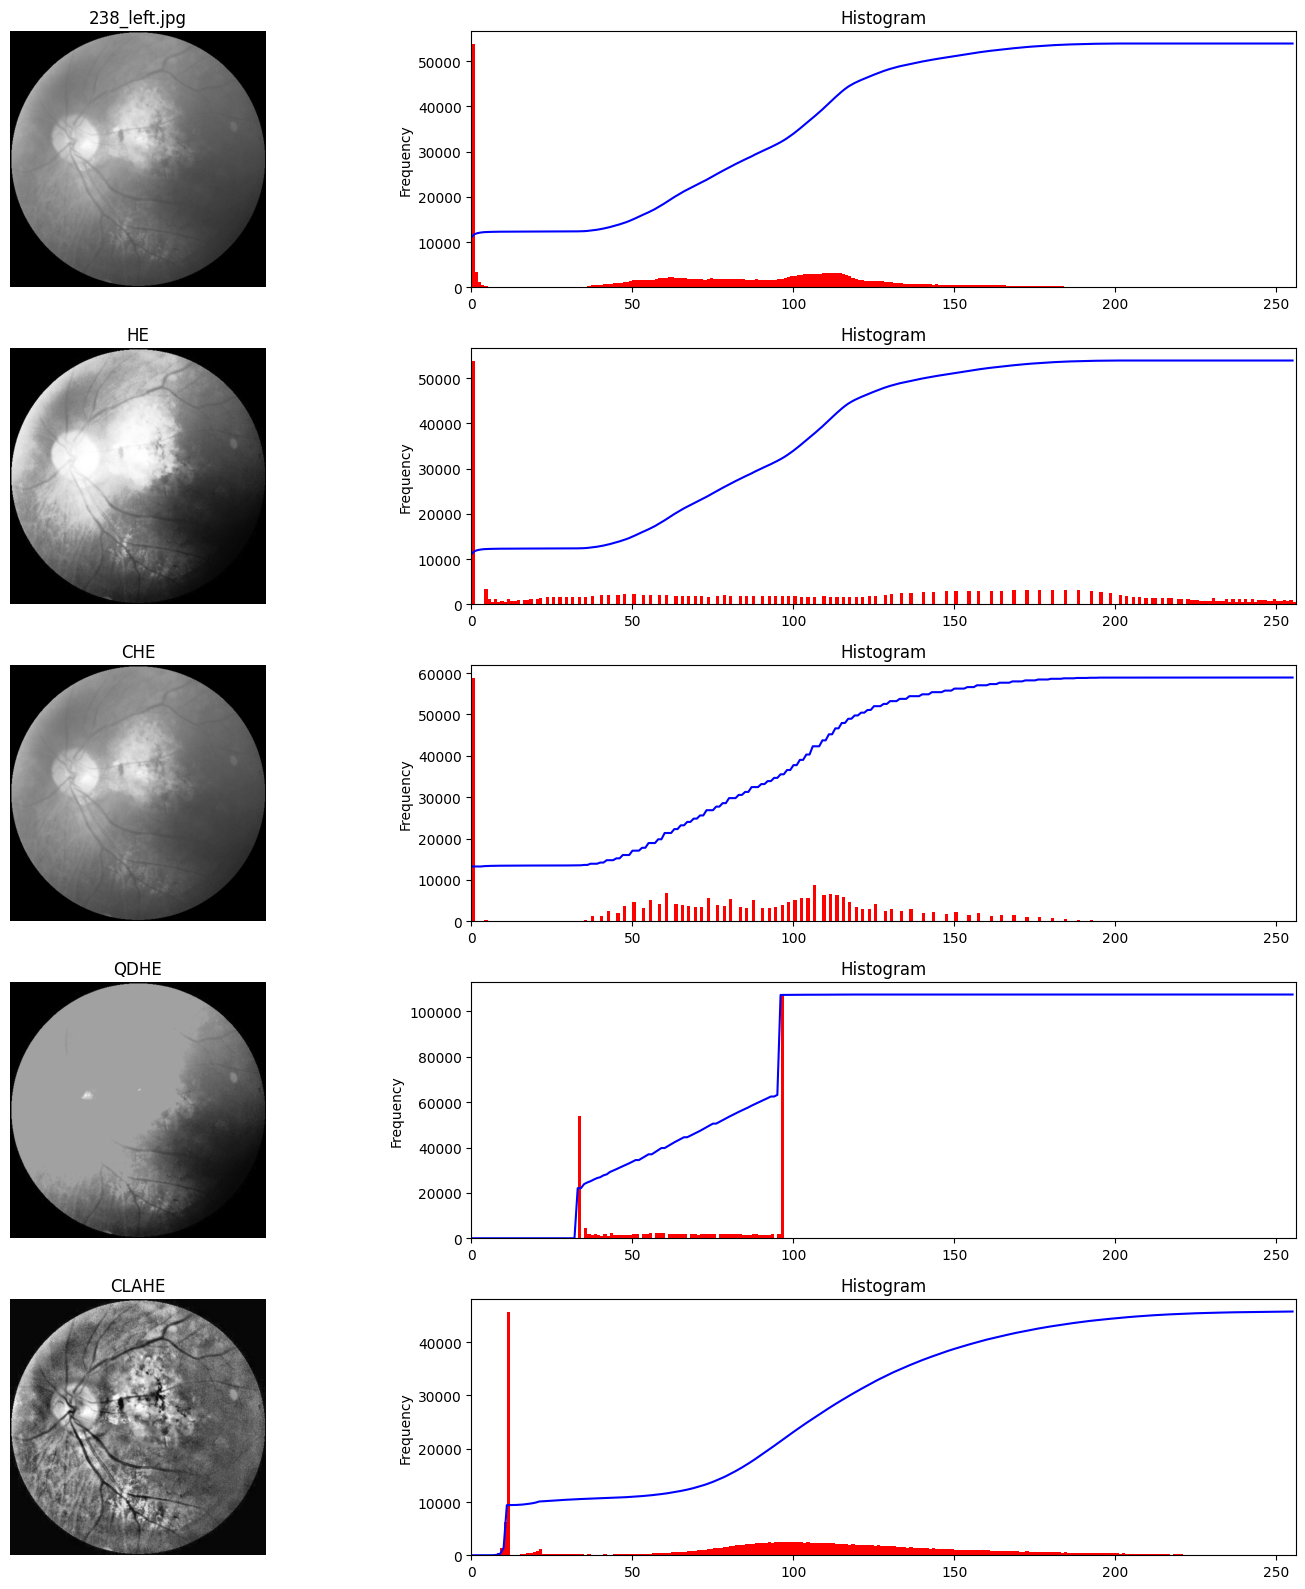

Method         MSE       PSNR         SD
0     HE   78.057961   0.616603  83.681427
1    CHE    0.904053  53.238934  49.325545
2   QDHE   60.844067   0.791052  26.366446
3  CLAHE  108.093773   0.445269  56.283326

In [94]:
path = "238_left.jpg"
return_metrics(path)

- Image Originale (238_left.jpg): L'image du fond d'œil semble assez sombre avec peu de contraste, rendant difficile la distinction des détails.


- Histogram Equalization (HE): L'égalisation d'histogramme standard a augmenté le contraste général de l'image. L'histogramme est plus étendu, indiquant une meilleure répartition des intensités lumineuses, mais cela peut aussi entraîner une surexposition de certaines zones.


-  Cumulative histogram equalization (CHE): L'image traitée avec CDF montre une amélioration du contraste moins intense que HE. L'histogramme et le CDF indiquent que les niveaux d'intensité sont plus équilibrés, ce qui peut être préférable pour maintenir des détails sans suramplification.


- Quadrant Dynamic Histogram Equalization (QDHE): Cette méthode a produit une image avec un contraste significativement amélioré. L'histogramme indique une répartition très concentrée des niveaux d'intensité, ce qui pourrait signifier que certaines zones sont trop ou pas assez exposées.

- Contrast Limited Adaptive Histogram Equalization (CLAHE): CLAHE a produit une image avec un meilleur contraste et une visibilité des détails. L'histogramme montre une distribution plus lisse et équilibrée, évitant les extrêmes de sur ou sous-exposition.




En considérant les métriques :


- MSE: CHE a le MSE le plus bas, ce qui suggère moins d'erreur par rapport à l'image originale. Cependant, un MSE bas ne signifie pas toujours une meilleure qualité perceptive.


- PSNR: CHE a le PSNR le plus élevé, ce qui pourrait indiquer une meilleure qualité de l'image en termes de fidélité par rapport au bruit.


- SD: HE a le SD le plus élevé, ce qui implique un contraste plus élevé. Cependant, cela pourrait aussi indiquer un contraste peut-être trop accentué par rapport à l'image originale.




C:\Users\HP\AppData\Local\Temp\ipykernel_13596\3560982479.py:33: RuntimeWarning: invalid value encountered in divide
  sub_cdf_normalized = sub_cdf * (range_ends[i] - range_starts[i]) / sub_cdf[-1] + range_starts[i]


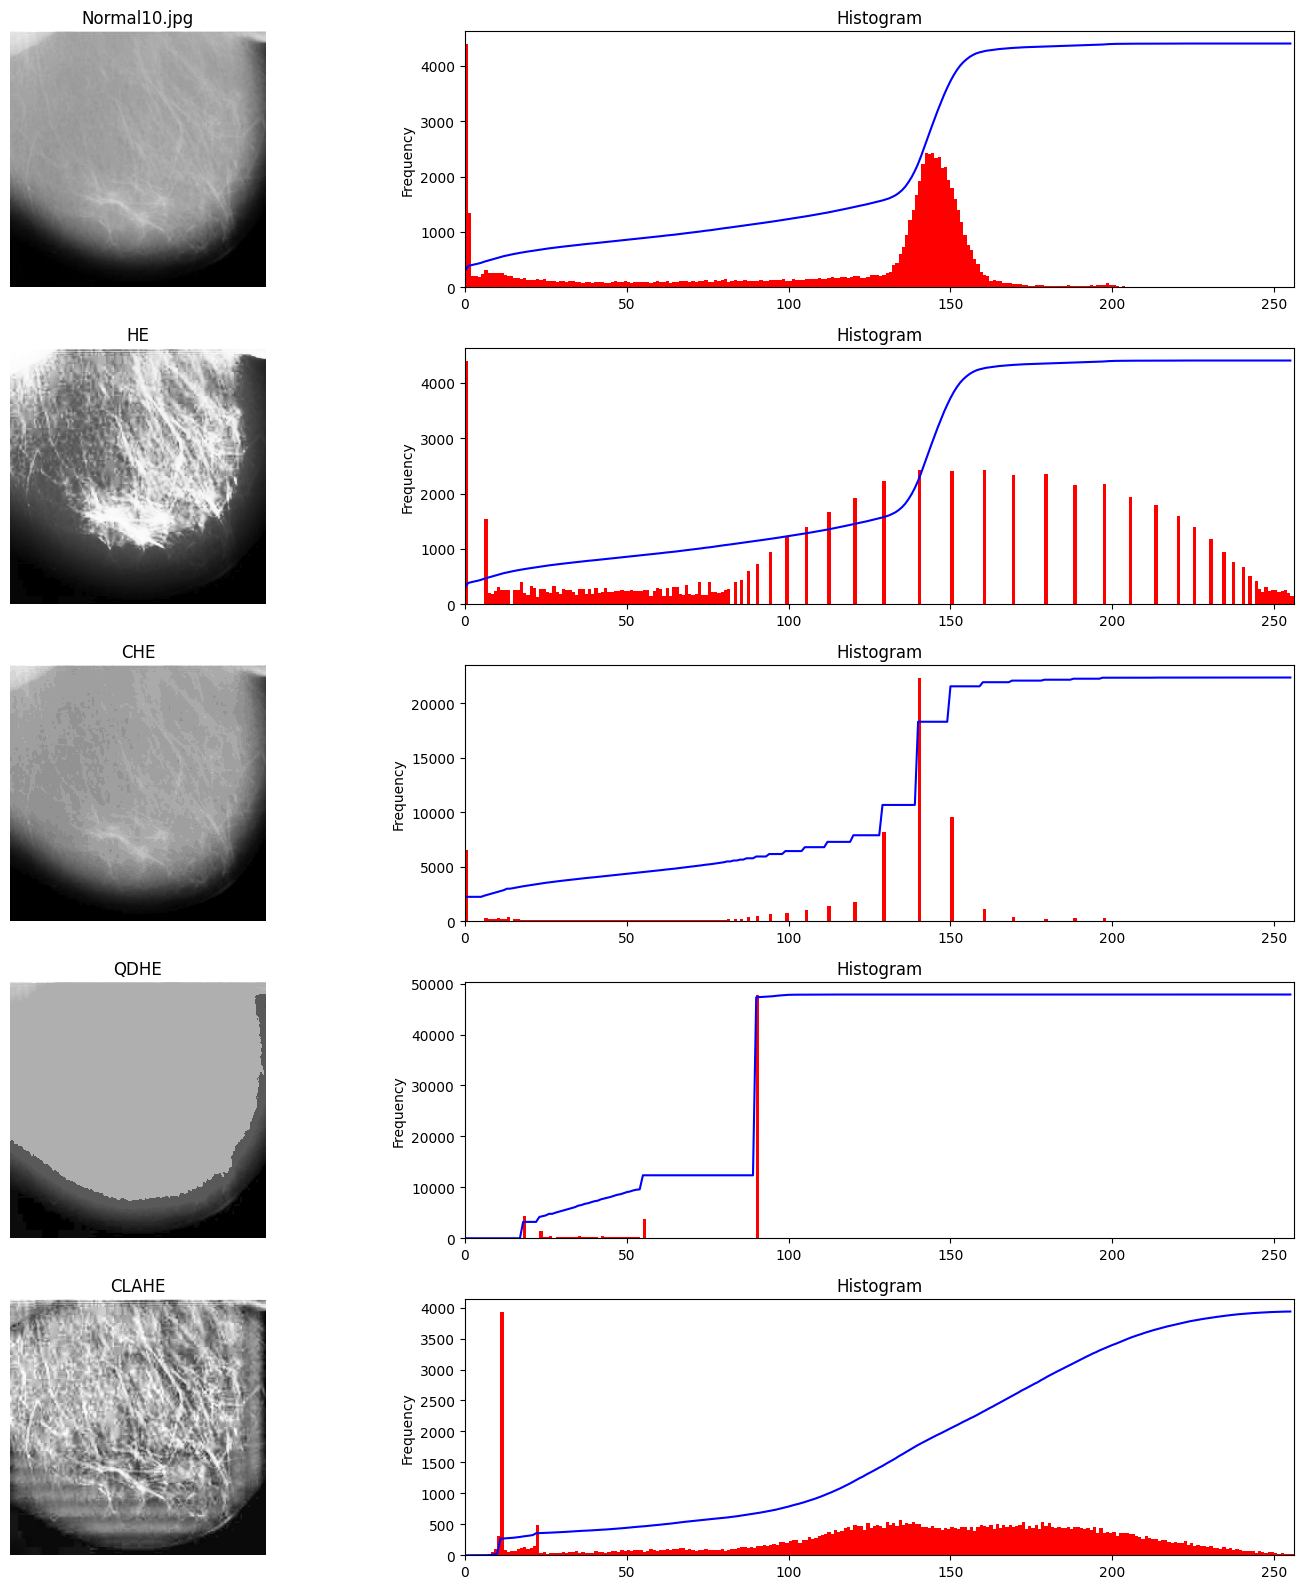

Method         MSE      PSNR         SD
0     HE   91.018158  0.528804  78.947831
1    CHE   20.993546  2.292648  52.808823
2   QDHE  114.460831  0.420500  24.964479
3  CLAHE  109.656021  0.438925  59.044856

In [95]:
path = "Normal10.jpg"
return_metrics(path)

- Histogram Equalization (HE): L'égalisation d'histogramme a nettement augmenté le contraste, comme le montre l'augmentation de la plage des intensités sur l'histogramme. Cependant, cela peut aussi augmenter le bruit apparent dans l'image.


-  Cumulative histogram equalization (CHE): L'image traitée avec CHE montre une amélioration du contraste, mais semble moins extrême que celle produite par HE. L'histogramme et le CDF suggèrent une augmentation du contraste tout en préservant une certaine uniformité dans la répartition des intensités.


- Quadrant Dynamic Histogram Equalization (QDHE): QDHE semble produire une image avec des niveaux de contraste plus équilibrés. Cependant, certaines zones peuvent sembler trop sombres ou trop claires, ce qui peut ne pas être idéal pour la détection de subtiles anomalies.


- Contrast Limited Adaptive Histogram Equalization (CLAHE): CLAHE a amélioré le contraste de manière significative tout en limitant le bruit. L'histogramme montre une distribution plus uniforme des intensités, ce qui est préférable pour une visualisation détaillée sans suramplification du bruit.




Concernant les métriques fournies :


- MSE: CHE présente le MSE le plus bas, ce qui suggère une amélioration de la qualité de l'image par rapport à l'original.


- PSNR:  CHE a le PSNR le plus élevé, indiquant potentiellement la meilleure qualité de reconstruction par rapport au bruit.


- SD: HE a le SD le plus élevé, ce qui suggère le contraste le plus fort.

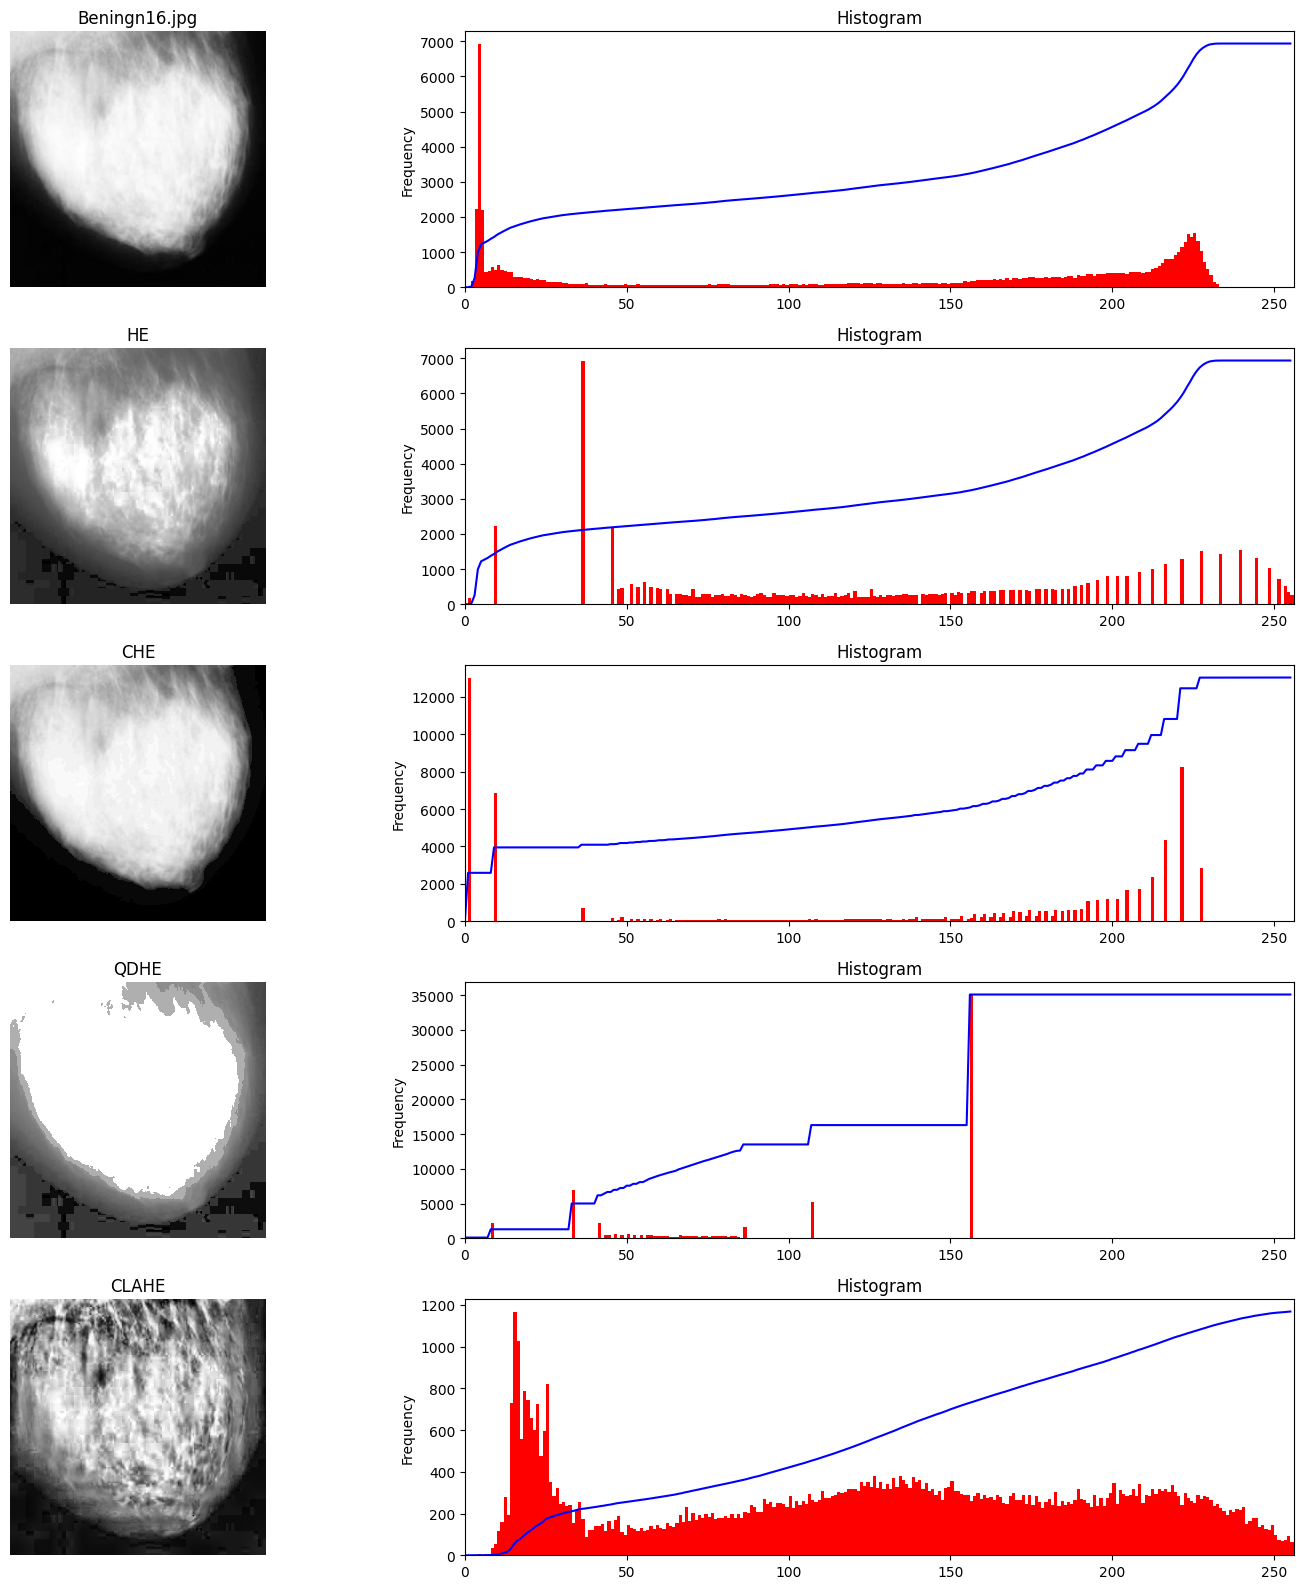

Method         MSE      PSNR         SD
0     HE   94.127777  0.511335  72.019113
1    CHE   18.385925  2.617807  90.888025
2   QDHE   93.688080  0.513735  52.469645
3  CLAHE  107.704361  0.446879  71.505872

In [96]:
path = "Beningn16.jpg"
return_metrics(path)

- Image Originale: L'image originale montre un tissu mammaire avec des zones de densité variable. L'histogramme est fortement orienté vers les faibles intensités, indiquant une image globalement sombre.


- Histogram Equalization (HE): L'application de HE a grandement augmenté le contraste de l'image. Cela se reflète dans l'histogramme avec une répartition plus large des intensités. Toutefois, cette méthode peut aussi amplifier le bruit.


-  Cumulative histogram equalization (CHE): L'image traitée avec CHE montre une amélioration du contraste mais avec moins de bruit apparent par rapport à HE. L'histogramme est légèrement plus équilibré, ce qui peut être préférable pour l'analyse clinique.


- Quadrant Dynamic Histogram Equalization (QDHE): QDHE semble produire une image avec des intensités très contrastées, ce qui pourrait ne pas être idéal pour la visualisation de détails subtils.


- Contrast Limited Adaptive Histogram Equalization (CLAHE): CLAHE offre une amélioration significative des détails et du contraste. L'histogramme montre une répartition des intensités plus uniforme sans les pics extrêmes de HE ou QDHE, ce qui pourrait aider à identifier des caractéristiques subtiles dans le tissu mammaire.



En examinant les métriques associées :


- MSE : CHE présente le MSE le plus bas, ce qui indique que cette méthode préserve mieux les détails originaux de l'image par rapport aux autres méthodes.


- PSNR : Encore une fois, CHE a le PSNR le plus élevé, ce qui suggère une meilleure conservation de l'image par rapport au bruit ajouté par l'égalisation.


- SD : CHE a le SD le plus élevé, ce qui reflète un contraste amélioré. Toutefois, un SD trop élevé peut parfois indiquer un contraste artificiellement amplifié.

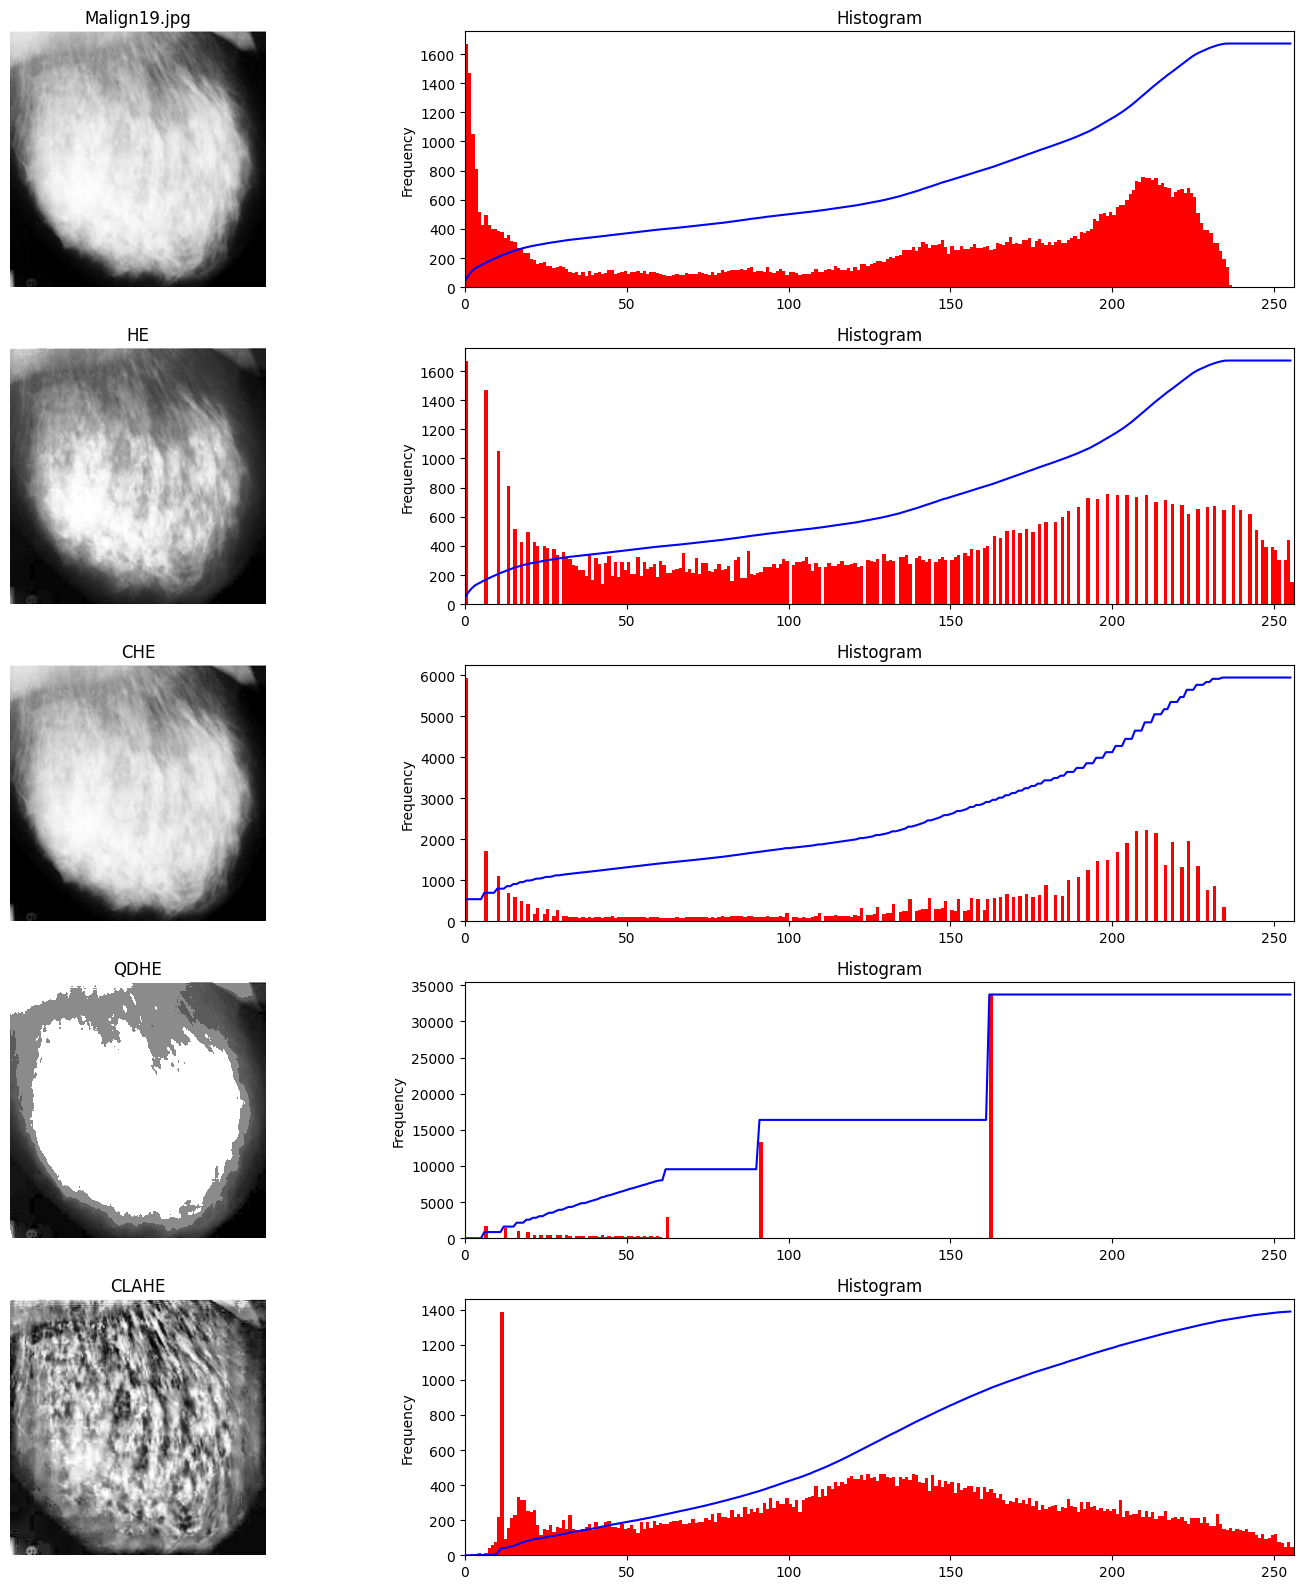

Method         MSE       PSNR         SD
0     HE  101.527664   0.474066  75.590618
1    CHE    1.337448  35.987043  78.654724
2   QDHE  105.484329   0.456284  55.743365
3  CLAHE  106.935608   0.450091  62.240109

In [97]:
path = "Malign19.jpg"
return_metrics(path)

- Image Originale: La première image semble être une mammographie standard, caractérisée par des zones de densité variable et une plage dynamique restreinte, comme le montre l'histogramme à gauche.


- Histogram Equalization (HE): L'application de HE a considérablement augmenté le contraste. Cela est visible dans l'histogramme par la large distribution des valeurs de pixels. Cependant, cette méthode peut augmenter le bruit perceptible et les artefacts.


-  Cumulative histogram equalization (CHE): L'égalisation par CHE a amélioré le contraste de manière plus subtile que HE. L'histogramme et le CDF indiquent une distribution des intensités plus douce, ce qui peut être plus approprié pour identifier des caractéristiques subtiles.


- Quadrant Dynamic Histogram Equalization (QDHE): QDHE semble fournir un contraste élevé avec une répartition plus marquée des niveaux de gris, comme le montre l'histogramme avec de grands pics et vallées.


- Contrast Limited Adaptive Histogram Equalization (CLAHE): CLAHE a permis d'obtenir une amélioration notable du contraste avec une plus grande clarté des structures. L'histogramme montre une répartition des intensités qui évite les extrêmes de l'égalisation d'histogramme classique.



Concernant les métriques :


- MSE : CHE offre le MSE le plus bas, ce qui suggère que cette méthode altère moins l'image originale par rapport aux autres méthodes d'égalisation.

- PSNR : CHE présente également le PSNR le plus élevé, ce qui indique une meilleure qualité d'image par rapport au bruit introduit par l'égalisation.


- SD : CHE a également un SD relativement élevé, ce qui signifie qu'elle offre un bon contraste sans exagération.